# SSE 1D Heisenberg

## I. Theory

The objective of the method is to calculate the expectation value of an observable $\hat{A}$ as follows:

$$
<\hat{A}> = \frac{1}{Z}Tr\left\{ \hat{A}e^{-\beta\hat{H}}\right\}
$$

with $Z = Tr\left\{ e^{-\beta\hat{H}}\right\}$.

The Hamiltonian is made up of a sum of non-commuting terms $\hat{H} = \sum^M_i \hat{H}_i , [\hat{H}_i,\hat{H}_j] \ne 0$ for any i, j

This trace can be rewritten in terms of a summation over the expectation values of product of Hamiltonian terms of a given order $n$ such as:

$$
Z = \sum^{\infty}_n \sum_{\{C_n\}} \frac{(-\beta)^n}{n!} Tr\left\{\prod^n_{j=1} \hat{H}_{l_j} \right\}
$$

Where $C_n$ gives all the possible combinations of product terms of bonds indices $(l_1,l_2,\dots,l_n)$ of order $n$ with $1\le l_i \le M$ where $M$ is the number of operators in the summation of the Hamiltonian terms $\hat{H}_i$.

With this reordering, the expectation value of an operator $<\hat{A}>$ can be written as:

$$
<\hat{A}> = \sum^{\infty}_n\sum_{\{C_n\}} A(C_n)W(C_n)
$$

where $A(C_n)$ and $W(C_n)$ are given by:

$$
A(C_n) =  Tr\left\{\hat{A}\prod^n_{j=1}\hat{H}_{l_j} \right\}\bigg/Tr\left\{\prod^n_{j=1}\hat{H}_{l_j} \right\} \ \text{if}\ W(C_n) \ne 0\\ 0,W(C_n) = 0
$$

$$
W(C_n) = \frac{1}{Z}\frac{(-\beta)^n}{n!}Tr\left\{\prod^n_{j=1}\hat{H}_{l_j} \right\}
$$

If the weights $W(C_n)$ are all positive, $<\hat{A}>$ can be sampled in a MC simulation and the value can be extracted.

$$
<\hat{A}> = <A(C_n)>_W
$$

The expectation value can be calculated by expanding the trace in terms of a basis representation which is chosen as a list of string with the $\hat{S}_{z_j}$ component of each site $\alpha=[S_1,S_2,\dots,S_N]$.

$$
<\hat{A}> = \frac{1}{Z}\sum_{\alpha}\sum^{L}_n \sum_{\{C_n\}} \frac{(-\beta)^n}{n!}<\alpha|\hat{A}\prod^{n}_{j=1}\hat{H}_{l_j}|\alpha>
$$

## II. Algorithm

The states are represented as a list of the per site $S^z_i$ values as follows:

$$
|\alpha> = |S^z_1,S^z_2,\dots,S^z_N>
$$

The Heisenberg Hamiltonian given below is simplified as follows

$$
\hat{H} = \sum^{B}_{b=1} \left[ \hat{S}^z_{i(b)}\cdot\hat{S}^z_{j(b)} + \frac{1}{2} \left( S^+_{i(b)}\cdot S^-_{j(b)} + S^-_{i(b)}\cdot S^+_{j(b)} \right) \right]
$$

The two parts of the Hamiltonian are broken down and shifted in order to make all the expectation values non-negative.

$$
\hat{H}_{1,b} = \frac{1}{4} - \hat{S}^z_{i(b)}\cdot\hat{S}^z_{j(b)} \\ \hat{H}_{2,b} = \frac{1}{2} \left( S^+_{i(b)}\cdot S^-_{j(b)} + S^-_{i(b)}\cdot S^+_{j(b)} \right) 
$$

Therefore, the Hamiltonian is written as:

$$
\hat{H} = -\sum^B_{b=1}\sum^2_a \left[ \hat{H}_{a,b} \right]
$$

with a phase convention for the off-diagonal operators.

The SSE operator products in the partition function are given by
$$
\prod^M_p \hat{H}_{a(p),b(p)}
$$

The lists $a(p)$ and $b(p)$ are stored in a vector which give the operators acting at each time step $p$

and the operator string is given by $opstring(p) = 2 b(p) + a(p) - 1$ with the identity represented by $0$.

The configuration is stored in the spin variable which contains $spin[i] = 2S^z_i$

The connection of pair of spins to a bond is stored in $bsites$ which is a $MaxM x 2$ matrix with $bsites[b,1]$ giving the ms of the 1st site and $bsites[b,2]$ giving the ms of the second site.


### a.) Visualize SSE config

An example of an SSE configuration and propagated states for $M=12$ and $8$ sites is shown below.

### b.) Make vertex list

The most important function to build then is the loop calculation algorithm which gives the list of all the closed loops for a given SSE configuration.

In [113]:
vlist = makeVertexListSimple(a,b,Nsites)
printVertexList(vlist)

l = 	  1			  2			  3			  4			  

	 [1]	40		 [2]	20		 [3]	17		 [4]	18	
	 [5]	36		 [6]	28		 [7]	9		 [8]	10	
	 [9]	7		 [10]	8		 [11]	21		 [12]	22	
	 [13]	47		 [14]	48		 [15]	45		 [16]	29	
	 [17]	3		 [18]	4		 [19]	38		 [20]	2	
	 [21]	11		 [22]	12		 [23]	25		 [24]	26	
	 [25]	23		 [26]	24		 [27]	30		 [28]	6	
	 [29]	16		 [30]	27		 [31]	33		 [32]	34	
	 [33]	31		 [34]	32		 [35]	46		 [36]	5	
	 [37]	39		 [38]	19		 [39]	37		 [40]	1	
	 [41]	0		 [42]	0		 [43]	0		 [44]	0	
	 [45]	15		 [46]	35		 [47]	13		 [48]	14	
	 [49]	0		 [50]	0		 [51]	0		 [52]	0	
	 [53]	0		 [54]	0		 [55]	0		 [56]	0	
	 [57]	0		 [58]	0		 [59]	0		 [60]	0	


### d.) Make loop list

Finally, all the closed loops need to be calculated for a given $opstring$ and set of bonds $b$ acting on a configuration $spin

For the above SSE configuration, the only big closed loop is:

## III. Updates

## 1. Diagonal update

The first type of update is the diagonal update where a $\hat{S}^z_b(p)$ operator is put for a randomly chosen bond $b$ and this is carried out for each time dimension $p$. 

The condition for adding a diagonal operator $\hat{S}^z_b(p)$ is that the two spins making up the bond $b$ i.e. $S_{i(b)}$ and $S_{j(b)}$ should be unequal i.e. the spins should be anti-parallel.

## 2.) Off diagonal update

The off diagonal update involves updating two off diagonal operators $S^+_{i(b)}\cdot S^-_{j(b)}$ at once.

## 3.) Loop update

Loop update involves long range changes where a loop is constructed and inverted with probability $\frac{1}{2}$.

# Final Algorithm

## 1. Put everything together

Combining all the elements we write the final algorithm which has the following steps:

    1. A cycle of diagonal updates
    2. Construct vertexlist
    3. Flip all loops with prob 1/2
    4. map vertexlist back to opstring and spin
 

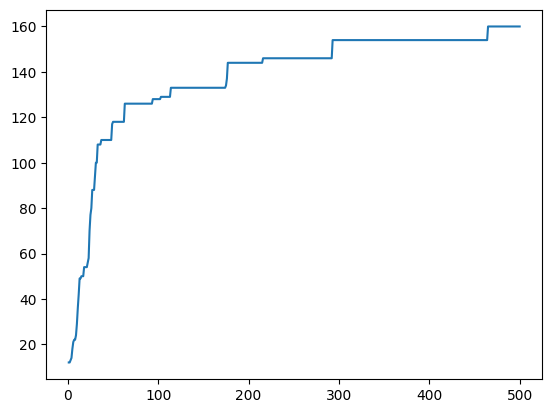

spin = [-1.0, 1.0, 1.0, 1.0, -1.0, 1.0, -1.0, -1.0]


1-element Array{PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x19ee27320>

In [177]:
# Initialize parameters
MaxM = M = 12
a = zeros(MaxM)
b = zeros(MaxM)
opstring = zeros(MaxM)
β = 20
n = 0

Nsites = 8
spin = [(i-0.5)/abs(i-0.5) for i in rand(Nsites)]
bsites = makeBsites(Nsites)
print("spin = ",spin,"\n")

maxMCsteps = 500
# ratio for MaxM vs n
α = 3


mlist = []
counterlist = []
countn = zeros(Int,maxMCsteps)
# Set up MC loop
mcsteps = 0
while mcsteps < maxMCsteps
    # 1. do diagonal updates
    n = diagUpdate!(a,b,opstring,spin,bsites,n,M,Nsites,β)
    if n == 0
        continue
    end
#    print("\tdone diag\t")
#    printmat(a)
#    printmat(b)
    if M - n < n/α 
        prevM = M
        M = trunc(Int,n + n/α)
        acopy = copy(a)
        bcopy = copy(b)
        opstringcopy = copy(opstring)
        a = zeros(M)
        a[1:prevM] = acopy
        b = zeros(M)
        b[1:prevM] = bcopy
        opstring = zeros(M)
        opstring[1:prevM] = opstringcopy
    end
    
    push!(mlist,M)
    countn[n] += 1
    
    # 2. construct vertexlist
    vlist = makeVertexListSimple(a,b,Nsites)
    
    mcsteps += 1   
    push!(counterlist,mcsteps)
    
#    print("> ",mcsteps,"\t M=",M,"\t")
    
    # 3. construct all loops and flip
    loops = constructAllLoops(vlist,M)
    
#    print(size(loops),"\t")
    
    if loops == -1 || size(loops)[1] == 0
#        print("\n")
        continue
    end
    
    # 4. do loop update
    loopUpdate!(loops,a,b,opstring,bsites)
    

    
#    print(mcsteps,"\t",n,"\t",M,"\n")
end
plot(counterlist,mlist)

## 2.) Visualize SSE configuration

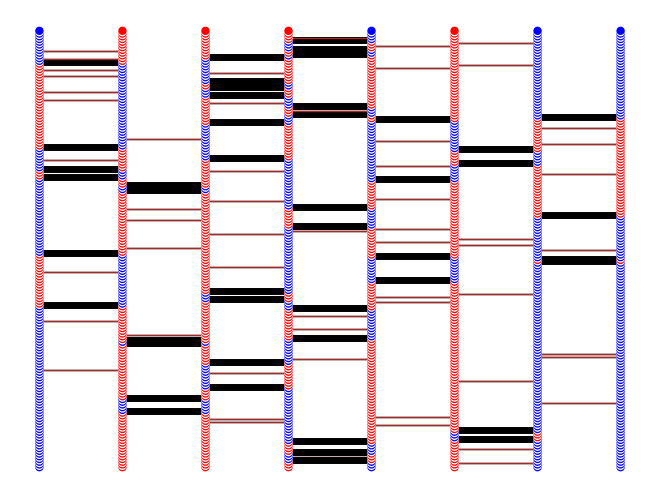

    -1.0       1.0       1.0       1.0       -1.0       1.0       -1.0       -1.0       

PyObject <matplotlib.collections.LineCollection object at 0x19f43cc88>

In [178]:
drawSSEConfig(Nsites,M,a,b,spin)

----------

# Function definitions

## 1.) buildOpstring

In [1]:
"""
Build opstring given the operator list a and b
"""
function buildOpstring!(opstring,a,b)
    dim = length(a);
    eye = ones(dim);
    idxa = a .== 0;
    idxb = b .== 0;
    eye[idxa] .= 0;
    opstring .= 2 * b + a - eye;
end

buildOpstring!

## 2.) Printmatrix

In [2]:
function printmat(mat)
    print("\n")
    show(Base.stdout, MIME"text/plain"(),mat)
    print("\n")
end

printmat (generic function with 1 method)

## 3.) Bsites

In [3]:
"""
Make Bsites for 1D Heisenberg\n
Nsites - the number of sites
"""
function makeBsites(Nsites)
    bsites = zeros(Nsites-1,2)
    bsites[:,1] = 1:Nsites-1
    bsites[:,2] = 2:Nsites
    return bsites
end


makeBsites

## 4.) Make graph with a given a and b

In [4]:
using ImageView, Images, TestImages
using PyPlot
using PyCall

"""
Draw SSE configuration with given
a(p) and b(p) operators.
Nsites - number of sites
MaxM - number of time steps
a - the op type
b - the bond id for each op
spin - the configuration list
"""
function drawSSEConfig(Nsites,MaxM,a,b,spin)
    # draw the given opstring


    nx = pyimport("networkx")

    m=2MaxM + 1
    n=Nsites

    G = nx.grid_2d_graph(n,m); # n, m grid 
    pos = Dict( (n, n) for n in G.nodes() );

    color_map=[]
    countcolor=1
    for i in 0:n-1
        for j in 0:m-1
            if countcolor%2 == 0
                push!(color_map,"white")
            else
                push!(color_map,"blue")
            end
            countcolor+=1
        end
        countcolor+=1
    end

    for j in 0:m-2
        for i in 0:n-2
            G.remove_edge((i,j),(i+1,j))
            G.remove_edge((i,j),(i,j+1))
        end
        G.remove_edge((n-1,j),(n-1,j+1))
    end
    for i in 0:n-2
        G.remove_edge((i,m-1),(i+1,m-1))
    end

    # make the ops by looping over the imaginary time axis
    # use a for the time direction and b for the space dimension
    #G.add_edge((0,m-2),(1,m-2))
    width=[]
    edge_color=[]
    for i in 1:MaxM
        if a[i] != 0 && b[i] < Nsites
            J = m-2*i
            I = trunc(Int,b[i]-1)
 #           print(I,"\t",J,"\n")
            if a[i]==1
                G.add_edge((I,J),(I+1,J))
                push!(width,1.0)
                push!(edge_color,"brown")
            else
                G.add_edge((I,J),(I+1,J))
                push!(width,5.0)
                push!(edge_color,"black")
            end
        end
    end


    edges=[]
    edge_color=[]
    width=[]
    for (i,edge) in enumerate(G.edges)
    #    edges[edge]=i
        push!(edges,edge)
        J = edge[2][1]
        I = trunc(Int,MaxM-(edge[2][2]-1)/2)
        if a[I]==2
            push!(width,5.0)
            push!(edge_color,"black")
        else
            push!(width,1.0)
            push!(edge_color,"brown")
        end
    end

    for j in 1:MaxM    
        J = m-2*(j-1)        
        for i in 0:n-1
            I=i
    #        print(J," ",I,"\t",J*(m-1)+I,"\n")
            if spin[i+1] == 1
                color_map[I*(m) + J] = "red"
            else
                color_map[i*(m) + J] = "blue"
            end
        end
        if a[j]==2
            for i in 0:n-1
                if b[j]==i+1
                    spin[i+1]*=-1
                    spin[i+2]*=-1
                end
            end 
        end
    end
    for i in 0:n-1
            J=m-2*(MaxM)
            I=i
            if spin[i+1] == 1
                color_map[I*(m) + J] = "red"
            else
                color_map[i*(m) + J] = "blue"
            end
     end

    print("    ")
    for i in 1:Nsites
        print(spin[i],"       ")
    end

    nx.draw(G,pos,node_color=color_map, font_color="white",node_size=25);
    nx.draw_networkx_edges(G,pos,edgelist=edges,width=width,edge_color=edge_color);
end

┌ Warning: PyPlot is using tkagg backend, which is known to cause crashes on MacOS (#410); use the MPLBACKEND environment variable to request a different backend.
└ @ PyPlot /Users/chilkuri/.julia/packages/PyPlot/4wzW1/src/init.jl:192


drawSSEConfig

## 6.) Print vertex list


In [37]:
"""
Print a given vertex list
vlist - the vertex list
"""
function printVertexList(vlist)  
    MaxM = size(vlist)[1]
    print("l = \t  ")
    for i in 1:4
        print(i,"\t\t\t  ")
    end
    print("\n\n")
    for i in 1:MaxM
        for j in 1:4
            print("\t [",4*(i-1) + j,"]","\t",vlist[i,j],"\t")
        end
        print("\n")
    end
end

printVertexList

## 7.) Find closed loop

In [85]:
"""
Find closed loops in the given SSE configuration
specified by vertex list
vertexlist - the current vertex list
startId - the id of the starting bond
legId - the id of the leg (=0,1,2,3) of the starting bond
"""
function findLoops(vertexlist,startId,legId)
    # construct a loop by traversing the vertexlist.
    # The rule is simply to follow the two steps:
    #     1. start by picking an element of vertexlist(p)
    #     2. go to the index pointed to by p
    #     3. if l(p) == 1 move to 2 or if l(p) == 2 move to 1 and similarly for 3,4
    #     4. go to vertexlist(p') and continue from step 1

    move = Dict()
    move[1]=2
    move[2]=1
    move[3]=4
    move[4]=3

    lpmove = Dict()
    lpmove[0]=4
    lpmove[1]=1
    lpmove[2]=2
    lpmove[3]=3
    
    pstart = startId
    p = startId
    lp = legId
    vstart = 4.0*(p-1) + lp
#    print("pstart=",p,"\t","lpstart=",lp," vstart=",vstart,"\n")
    
    q = 0
    v = 0
    loopids = []
    legids = []
    listp = []
    listlp = []
    push!(loopids,p)
    count = 1
    while v != vstart  #&& count < 50
        v = vertexlist[p,lp]
        push!(legids,v)
        push!(listp,p)
        push!(listlp,lp)
        lp = lpmove[trunc(Int,v%4)]
        p = trunc(Int,1 + (v-lp)/4)
        push!(legids,vertexlist[p,lp])
        push!(listp,p)
        push!(listlp,lp)
#        print(">",p,"\t",lp,"\t",v,"\n")
        lp = move[lp]
        q = p
        lq = lp
        count += 1
#        print(count,"\t",p,"\t",lp,"\t v=",4*(p-1)+lp,"\n")
        if v==vstart
            break
        end        
        v = 4.0*(p-1) + lp
        push!(loopids,p)
    end
    push!(legids,vertexlist[p,lp])
    push!(listp,p)
    push!(listlp,lp)
    return(loopids,legids,listp,listlp)
end

findLoops

## 8.) Diagonal update

In [146]:
import Random

"""
Get diag update addition probability
"""
function diagProbAdd(B,β,M,n)
    return (min((B*β/2)/(M-n),1))
end

"""
Get diag update removal probability
"""
function diagProbRemove(B,β,M,n)
    return (min((M-n+1)/(B*β/2),1))
end

#Random.seed!(1234)
"""
Return a random number [0,1)
"""
function getRand()
    return rand()
end

"""
The function that implements diagonal update\n
a - bond type
b - bond id
opstring - combind bond type and id
spin - the spin configuration
bsites - site list for each bond
MaxM - the time dimension
Nsites - number of sites
β - time step
"""
function diagUpdate!(a,b,opstring,spin,bsites,n,MaxM,Nsites,β)
#    Random.seed!(1001)
    B = Nsites-1
#    printmat(a)
    for i in 1:MaxM
        rnd = getRand()
        bnd = trunc(Int,B*rnd)+1
#        print(">",rnd,"\t",bnd,"\t")
        spin1 = spin[trunc(Int,bsites[bnd,1])]
        spin2 = spin[trunc(Int,bsites[bnd,2])]
#        print(i,"\t",bnd,"\t",spin1,"\t",spin2,"\n")
#        printmat(spin)
#        print("\n")
        if spin1 != spin2 && a[i] == 0
            probAc = diagProbAdd(B,β,MaxM,n)
            rnd = getRand()
            if rnd < probAc
                # accept update
                b[i] = bnd
                a[i] = 1
                opstring[i] = 2 * bnd
                n += 1
            end
        elseif a[i] == 1
            probRm = diagProbRemove(B,β,MaxM,n)
            rnd = getRand()
            if rnd < probRm
                # remove bond
                b[i] = 0.0
                a[i] = 0.0
                opstring[i] = 0.0
                n -= 1
            end
        end
        if a[i] == 2
            # propagate the state
            spin[trunc(Int,bsites[trunc(Int,b[i]),1])] *=-1
            spin[trunc(Int,bsites[trunc(Int,b[i]),2])] *=-1
        end
    end
    return n
end

diagUpdate!

## 9.) Off diagonal pair update

In [9]:
"""
Generate the list of all the pair of operators type 2 for 
the off-diagonal update
looplist - list of loops
a - list of bond types
b - list of bond ids
opstring - opstring
bsites - spin ids for each bond
"""
function offdiagonalUpdate!(looplist,a,b,opstring,bsites)
    
    lpmove = Dict()
    lpmove[0]=4
    lpmove[1]=1
    lpmove[2]=2
    lpmove[3]=3
    
    opinvert = Dict()
    opinvert[1.0] = 2.0
    opinvert[2.0] = 1.0
    
    nloops = size(looplist)
    loopdims = map(x->size(x)[1],looplist)
    idxoffdiagloops = findall(x->x==5,loopdims)
    numoffdiagloops = size(idxoffdiagloops)[1]
    for i in 1:numoffdiagloops
        id = idxoffdiagloops[i]
        v1  = looplist[id][1]
        v2  = looplist[id][2]
        lp1 = lpmove[v1%4]
        p1  = trunc(Int,1 + (v1-lp1)/4)        
        lp2 = lpmove[v2%4]
        p2  = trunc(Int,1 + (v2-lp2)/4)        
#        print(i,"\t",v1,"\t",v2,"\n")
        if v1 > v2
            # winded through periodic edges
            # need to change spin configuration
            a[p1] = opinvert[a[p1]]
            a[p2] = opinvert[a[p2]]            
            opstring[p1] = 2*b[p1] + a[p1] - 1
            opstring[p2] = 2*b[p2] + a[p2] - 1
            b1 = trunc(Int,b[p1])
            b2 = trunc(Int,b[p2])
            if b1 != b2
                print("Something is wrong in off diag up b1 != b2\n")
            end
            s1 = trunc(Int,bsites[b1,1])
            s2 = trunc(Int,bsites[b1,2])
            spin[s1] *= -1
            spin[s2] *= -1
        else
            # direct loop 
            # no need to change spin configurations
            a[p1] = opinvert[a[p1]]
            a[p2] = opinvert[a[p2]]
            opstring[p1] = 2*b[p1] + a[p1] - 1
            opstring[p2] = 2*b[p2] + a[p2] - 1
        end       
    end
end

offdiagonalUpdate!

## 10.) Loop update

In [10]:
"""
Generate the list of all the pair of operators with loop dim  > 5 for 
the loop update
looplist - list of loops
a - list of bond types
b - list of bond ids
opstring - opstring
bsites - spin ids for each bond
"""
function loopUpdate!(looplist,a,b,opstring,bsites)
    
    lpmove = Dict()
    lpmove[0]=4
    lpmove[1]=1
    lpmove[2]=2
    lpmove[3]=3
    
    opinvert = Dict()
    opinvert[1.0] = 2.0
    opinvert[2.0] = 1.0
    
    donea = zeros(Int,size(a))
            
    nloops = size(looplist)
    loopdims = map(x->size(x)[1],looplist)
    idxloops = findall(x->x>0,loopdims)
    numloops = size(idxloops)[1]
    for i in 1:numloops
        id = idxloops[i]
#        print(i,"\t",id,"\t",loopdims[id],"\t")
        rnd = rand()
        if rnd >= 0.5
            for j in 1:loopdims[id]-1
                v1  = looplist[id][j]
                lp1 = lpmove[v1%4]
                p1  = trunc(Int,1 + (v1-lp1)/4)        
                donea[p1] += 1
    #            print(p1,"\n")
                # direct loop 
                # no need to change spin configurations 
                if donea[p1] %2 == 0
                    a[p1] = opinvert[a[p1]]
                    opstring[p1] = 2*b[p1] + a[p1] - 1
                end

            end 
            donea = zeros(Int,size(a))
        end
    end
end

loopUpdate!

## 11.) Construct all loops

In [11]:
"""
Construct all loops given vlist
vlist - the vertexlist
"""
function constructAllLoops(vlist,MaxM)
    
    traversedvertices = ones(Int,MaxM, 4)
    zerosid = findall(x->x == 0,vlist)
    traversedvertices[zerosid] .= 0
    loops = []
    nones = MaxM*4
    nonzerosid = findall(x->x != 0,vlist)
    if size(nonzerosid)[1] > 0
        
        v1 = vlist[nonzerosid[1]]
        
        lpmove = Dict()
        lpmove[0]=4
        lpmove[1]=1
        lpmove[2]=2
        lpmove[3]=3

        lp = lpmove[v1%4]
        p  = trunc(Int,1 + (v1-lp)/4)
        while nones > 0
            bids, legids, listp, listlp = findLoops(vlist,p,lp);
            push!(loops,legids)
            for (a,b) in zip(listp[1:end-1],listlp[1:end-1])
                traversedvertices[a,b] *= -1
            end
            idones = findall(x->x == 1,traversedvertices)
            nones = size(idones)[1]
            if nones > 0
                p = idones[1][1]
                lp = idones[1][2]
            end
        end
        return(loops)
    else
        return(-1)
    end
end

constructAllLoops

## 12.) Make vertex list improved

In [112]:
"""
A function that combines two lists and returns a sorted list.
"""
function mergesorted(a,b) 
    return(sort!(vcat(a,b)))
end


"""
A simple version to make the vertex list
we simply combine the off-diagonal and diagonal terms.
a - the bond types
b - the bond ids of each bond
"""
function makeVertexListSimple(a,b,Nsites)
    # Get the dimension
    MaxM = size(a)[1]
#    print("MaxM=",MaxM,"\n")
    
    # find the number of operators
    # and their locations
    op_ids = findall(x->x > 0,a)
    num_op = size(op_ids)[1]

    # get bond corresponding to each operator
    bond_op = b[op_ids]

    # get bond type
    bond_type = a[op_ids] 
    
    cyclic_ids = Dict()
    for i in 1:Nsites-1
        cyclic_ids[i] = i
    end
    cyclic_ids[Nsites] = -1
    cyclic_ids[0] = -1
    
    vlist = zeros(Int,MaxM,4)
    
    boolToId_prev = Dict()
    boolToId_prev[true]  = 3
    boolToId_prev[false] = 4
    
    boolToId_next = Dict()
    boolToId_next[true]  = 4
    boolToId_next[false] = 3
    
    lpNext = Dict()
    lpNext[3] = 1
    lpNext[4] = 2
    
    done_prev = false
    done_next = false

    # make the list of op ids which act on bond ids
    # one before and one after the current bond id
    # e.g.
    # -a-|
    #    |
    #    |    |-b-
    #    |-e--|
    #    |    |
    #    1    2
    #     ----
    #    3    4
    #    |    |
    # -c-|    |
    #    |    |-d-
    #    |-f--|
    #
    # the stored indices will be [1,2,4,5] each for the
    # four legs
    diff_bond_list = zeros(num_op,4)
    for i in 1:num_op
        p = op_ids[i]   
        
        done_prev = false
        done_next = false
        
        bid_i = trunc(Int,bond_op[i])
        bid_im1 = cyclic_ids[bid_i - 1]
        bid_ip1 = cyclic_ids[bid_i + 1]
        
        diag_idlist = filter!(x->x != i,findall(x->x == bid_i, bond_op))
        prev_idlist = findall(x->x == bid_im1, bond_op)
        next_idlist = findall(x->x == bid_ip1, bond_op)
        
        blist_prev = mergesorted(prev_idlist,diag_idlist)
        nbids_prev = size(blist_prev)[1]
        blist_next = mergesorted(diag_idlist,next_idlist)
        nbids_next = size(blist_next)[1]
        
        if nbids_prev == 0
            blist_prev = [i]
            ids_adjascent_prev = [1]
            nbids_prev = 1
            done_prev = true
        end
        if nbids_next == 0
            blist_next = [i]
            ids_adjascent_next = [1]
            nbids_next = 1
            done_next = true
        end

        if !done_prev
            ids_adjascent_prev = [searchsortedlast(blist_prev,i),searchsortedfirst(blist_prev,i)]
        
            # adjust for the case where i is at 0 or end
            if ids_adjascent_prev[1] == 0 || ids_adjascent_prev[2] == nbids_prev + 1
                if nbids_prev == 1
                    ids_adjascent_prev = [1]
                    nbids_prev = 1
                else
                    ids_adjascent_prev = [nbids_prev,1]
                    nbids_prev = 2
                end
            end
        end
        if !done_next
            ids_adjascent_next = [searchsortedlast(blist_next,i),searchsortedfirst(blist_next,i)]
        
            # adjust for the case where i is at 0 or end
            if ids_adjascent_next[1] == 0 || ids_adjascent_next[2] == nbids_next + 1
                if nbids_next == 1
                    ids_adjascent_next = [1]
                    nbids_next = 1
                else
                    ids_adjascent_next = [nbids_next,1]
                    nbids_next = 2
                end
            end
        end

        
#        print(i,"\t",bid_im1,"\t",bid_i,"\t",bid_ip1,"\t",blist_prev,"\t",blist_next,"\n")
#        print("\t>",ids_adjascent_prev,"\t",nbids_prev,"\n")
#        print("\t>",ids_adjascent_next,"\t",nbids_next,"\n")
        
        
        # assign left ids to vertexlist
        if nbids_prev == 1
            pid_prev = blist_prev[ids_adjascent_prev[1]]
            p_id = op_ids[pid_prev]
            if isinvec(diag_idlist,pid_prev) || pid_prev == i
                vlist[p,1] = 4*(p_id - 1) + 3
                vlist[p,3] = 4*(p_id - 1) + 1
            else
                vlist[p,1] = 4*(p_id - 1) + 4
                vlist[p,3] = 4*(p_id - 1) + 2              
            end
        else
            pid_left_up = blist_prev[ids_adjascent_prev[1]]
            p_id_up = op_ids[pid_left_up]
            pid_left_dn = blist_prev[ids_adjascent_prev[2]]
            p_id_dn = op_ids[pid_left_dn] 
            
            # get lp
            lp_up = boolToId_prev[isinvec(diag_idlist,pid_left_up)]
            lp_dn = lpNext[boolToId_prev[isinvec(diag_idlist,pid_left_dn)]]
            
            # set vlist
            vlist[p,1] = 4*(p_id_up - 1) + lp_up
            vlist[p,3] = 4*(p_id_dn - 1) + lp_dn
        end
        
        # assign right ids to vertexlist
        if nbids_next == 1
            pid_next = blist_next[ids_adjascent_next[1]]
            p_id = op_ids[pid_next]
            if isinvec(diag_idlist,pid_next) || pid_next == i
                vlist[p,2] = 4*(p_id - 1) + 4
                vlist[p,4] = 4*(p_id - 1) + 2
            else
                vlist[p,2] = 4*(p_id - 1) + 3
                vlist[p,4] = 4*(p_id - 1) + 1              
            end
        else
            pid_right_up = blist_next[ids_adjascent_next[1]]
            p_id_up = op_ids[pid_right_up]
            pid_right_dn = blist_next[ids_adjascent_next[2]]
            p_id_dn = op_ids[pid_right_dn] 
            
            # get lp
            lp_up = boolToId_next[isinvec(diag_idlist,pid_right_up)]
            lp_dn = lpNext[boolToId_next[isinvec(diag_idlist,pid_right_dn)]]
            
            # set vlist
            vlist[p,2] = 4*(p_id_up - 1) + lp_up
            vlist[p,4] = 4*(p_id_dn - 1) + lp_dn
        end

    end
    return vlist
end

makeVertexListSimple

## 13.) Exists in vector function

In [13]:
"""
Check if an element exists in vector
vec - vector
x - element
"""
function isinvec(vec,x)
    if size(findall(y->y==x,vec))[1] >0
        return true
    else
        return false
    end
end

isinvec